# Loading Dataset

In [1]:
import pandas as pd

In [2]:
chunksize = 5_000_000
file_path = "rba-dataset/rba-dataset.csv"

chunk_1  = None
chunk_test = None
for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunksize)):
    if i == 0:
        chunk_1 = chunk
    elif i == 1:
        chunk_test = chunk
    else:
        break

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

# Exploração

<Axes: xlabel='Login Successful', ylabel='count'>

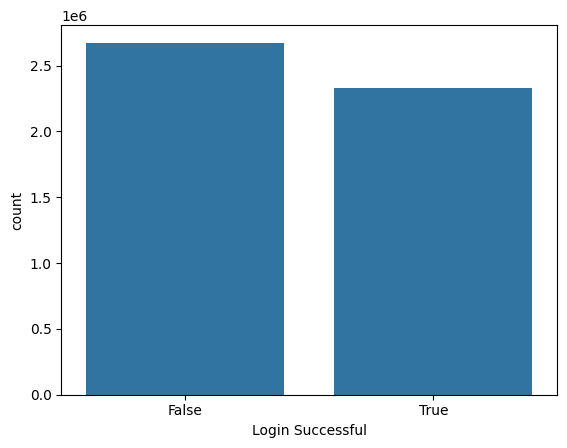

In [ ]:
import seaborn as sns

# Count Plot of Login Successful
sns.countplot(x='Login Successful', data=chunk_1)

<Axes: xlabel='Is Attack IP', ylabel='count'>

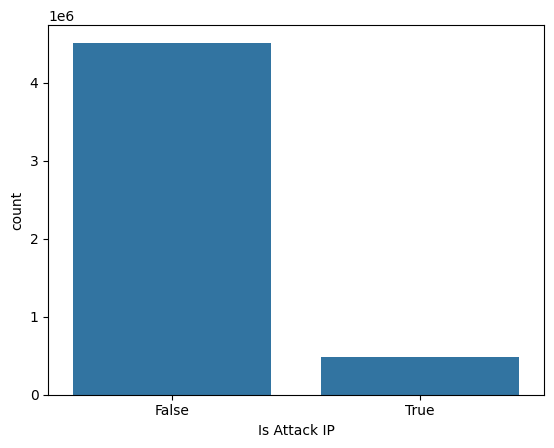

In [21]:
# Count plot of 'Is Attack IP'
sns.countplot(x='Is Attack IP', data=chunk_1)

<Axes: xlabel='Is Account Takeover', ylabel='count'>

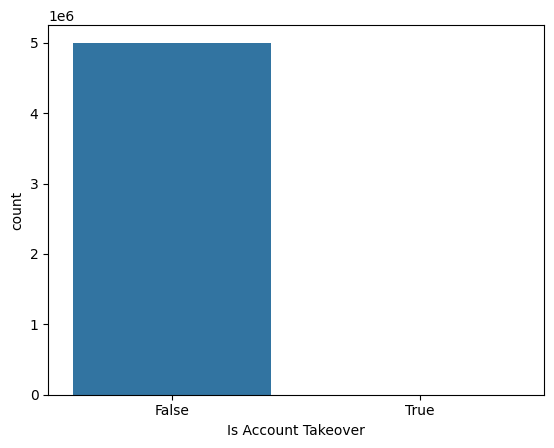

In [22]:
# Count Plot 'Is Account Takeover'

sns.countplot(x='Is Account Takeover', data=chunk_1)

<Axes: xlabel='Device Type', ylabel='count'>

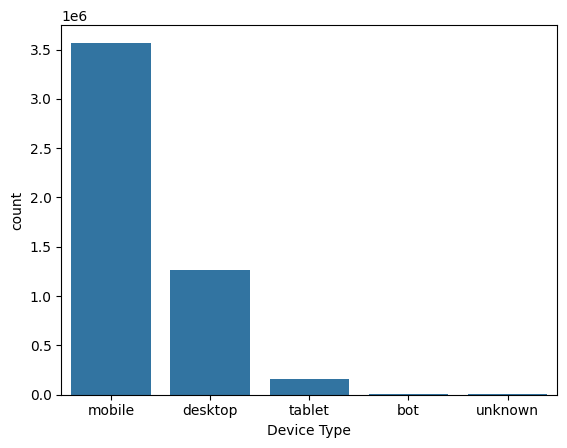

In [23]:
# Count Plot of 'Browser Name and Version'

sns.countplot(x='Device Type', data=chunk_1)

<Axes: xlabel='Device Type', ylabel='count'>

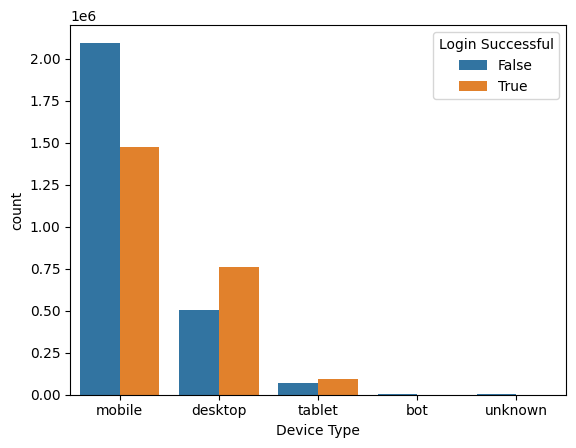

In [24]:
sns.countplot(x='Device Type', data=chunk_1, hue='Login Successful')

<Axes: xlabel='Device Type', ylabel='count'>

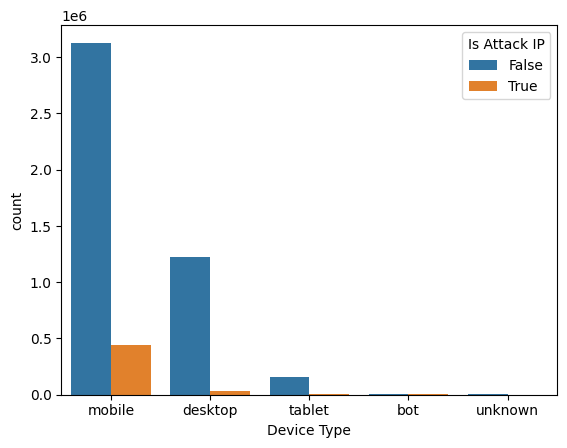

In [25]:
sns.countplot(x='Device Type', data=chunk_1, hue='Is Attack IP')

<Axes: xlabel='Device Type', ylabel='count'>

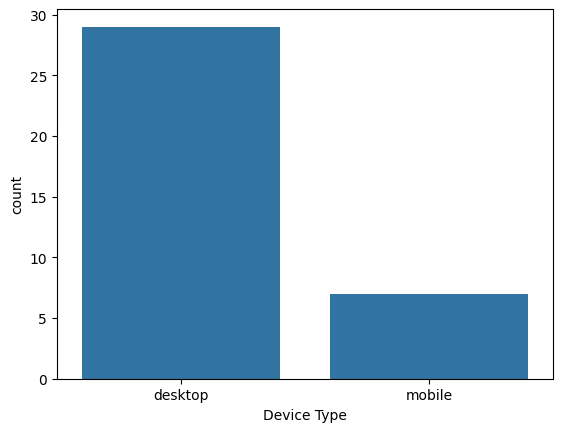

In [29]:
sns.countplot(x='Device Type', data=chunk_1[chunk_1['Is Account Takeover'] == True])

In [70]:
chunk_1.Country.value_counts()

Country
NO    2307876
US    1220450
PL     273144
BR     215790
IN     109279
       ...   
TC          1
NU          1
LC          1
BV          1
WF          1
Name: count, Length: 219, dtype: int64

# Tratamento

In [30]:
train_df = chunk_1.iloc[:, :-3]
train_df = train_df.drop(columns=['Round-Trip Time [ms]', 'index', 'User ID'])
print(train_df.columns)

Index(['Login Timestamp', 'IP Address', 'Country', 'Region', 'City', 'ASN',
       'User Agent String', 'Browser Name and Version', 'OS Name and Version',
       'Device Type'],
      dtype='object')


In [31]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical_columns(df):
    """Encodes categorical columns in a DataFrame using LabelEncoder."""
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    le = LabelEncoder()

    for col in categorical_cols:
        df[col] = le.fit_transform(df[col].astype(str))

    return df

In [32]:
df = encode_categorical_columns(train_df.copy())
df.columns

Index(['Login Timestamp', 'IP Address', 'Country', 'Region', 'City', 'ASN',
       'User Agent String', 'Browser Name and Version', 'OS Name and Version',
       'Device Type'],
      dtype='object')

In [35]:
df.head()

,Login Timestamp,IP Address,Country,Region,City,ASN,User Agent String,Browser Name and Version,OS Name and Version,Device Type
0,0,24845,146,1,7,29695,94334,1274,296,2
1,1,440899,10,1,7,60117,17966,742,22,2
2,2,852861,146,1694,19110,29695,61293,84,331,2
3,3,318982,202,1,7,393398,26387,1087,22,2
4,4,114,202,1709,1003,398986,42796,1087,13,2


In [36]:
test_df = chunk_test.iloc[:, :-3]
test_df = test_df.drop(columns=['Round-Trip Time [ms]', 'index', 'User ID'])
print(test_df.columns)

Index(['Login Timestamp', 'IP Address', 'Country', 'Region', 'City', 'ASN',
       'User Agent String', 'Browser Name and Version', 'OS Name and Version',
       'Device Type'],
      dtype='object')


In [37]:
test_df = encode_categorical_columns(test_df.copy())
test_df.columns

Index(['Login Timestamp', 'IP Address', 'Country', 'Region', 'City', 'ASN',
       'User Agent String', 'Browser Name and Version', 'OS Name and Version',
       'Device Type'],
      dtype='object')

# Isolation Forest Baseline

In [47]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=1000, contamination='auto')

In [48]:
model.fit(df)

IsolationForest(n_estimators=1000)

In [49]:
anomaly_scores = model.decision_function(test_df.iloc[:1000, :])

In [50]:
eval_df = test_df.iloc[:1000, :].copy()
eval_df['anomaly_score'] = anomaly_scores

In [51]:
eval_df.anomaly_score.describe()

count    1000.000000
mean       -0.014491
std         0.036884
min        -0.131456
25%        -0.038455
50%        -0.011307
75%         0.011421
max         0.044448
Name: anomaly_score, dtype: float64

In [52]:
chunk_test.head().iloc[:, -3:]

,Login Successful,Is Attack IP,Is Account Takeover
5000000,False,False,False
5000001,True,True,False
5000002,True,False,False
5000003,False,True,False
5000004,False,False,False


In [56]:
higher_risk = eval_df[eval_df.anomaly_score > -0.07291]
higher_risk_idx = higher_risk.index
chunk_test.loc[higher_risk_idx].head()

,index,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,User Agent String,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover
5000000,5000000,2020-04-11 16:26:28.794,-4324475583306591935,NaN,195.177.116.59,UA,-,-,28907,Mozilla/5.0 (Linux; Android 4.1; Galaxy Nexus...,Chrome Mobile WebView 80.0.3987,Android 4.1,mobile,False,False,False
5000001,5000001,2020-04-11 16:26:29.441,-6746597329256444707,NaN,94.142.130.177,US,-,-,54903,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile WebView 85.0.4183,iOS 11.2.6,mobile,True,True,False
5000002,5000002,2020-04-11 16:26:29.743,-6127174738776167247,NaN,79.160.28.125,NO,Vestland,Svortland,29695,Mozilla/5.0 (Linux; Android 4.1.1; NX007HD8G)...,Opera Mobile 52.1.2254.2306,Android 4.1.1,mobile,True,False,False
5000003,5000003,2020-04-11 16:26:30.838,-4324475583306591935,NaN,209.236.117.52,US,-,-,393398,Mozilla/5.0 (Mobile; Windows Phone 8.1; Andro...,Chrome Mobile 81.0.4044,Windows Phone 8.1,mobile,False,True,False
5000004,5000004,2020-04-11 16:26:31.296,-4324475583306591935,NaN,213.234.75.69,NO,-,-,43905,Mozilla/5.0 (Linux; U; Android 13.0; i phone X...,Opera Mobile 52.1.2254,Android 13.0,mobile,False,False,False


In [57]:
higher_risk.head()

,Login Timestamp,IP Address,Country,Region,City,ASN,User Agent String,Browser Name and Version,OS Name and Version,Device Type,anomaly_score
5000000,0,406867,201,1,7,28907,25040,1148,26,2,0.005136
5000001,1,1042424,203,1,7,54903,77285,1150,286,2,-0.014892
5000002,2,686863,148,1573,16496,29695,16929,1832,27,2,-0.049238
5000003,3,428196,203,1,7,393398,50932,824,265,2,0.039952
5000004,4,449319,148,1,7,43905,128845,1802,12,2,-0.012110


# Eval

In [67]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(test_df.iloc[:1000, :])
y_pred = [-1 if x > -0.07291 else 1 for x in y_pred]
y_true = [-1 if x == False else 1 for x in chunk_test.iloc[:1000, 13]]
confusion_matrix(y_true, y_pred)

array([[243, 359],
       [139, 259]])

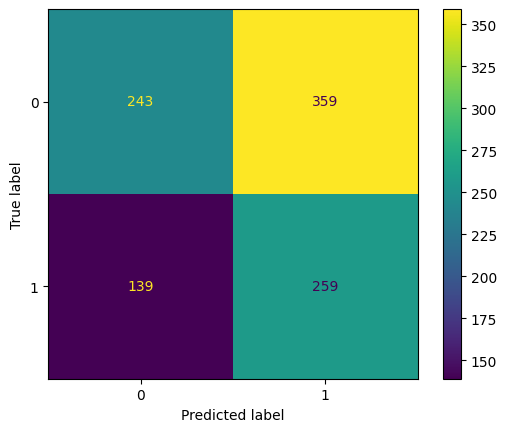

In [68]:
from matplotlib import pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred))
disp.plot()
plt.show()